In [39]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime

from utils.neural_network import train_nn, get_device

from models.KF import KF
from utils.load_data import load_data, load_gt_data
from utils.preprocessing_v2 import Preprocessing, get_gt_diff_logs
import utils.results as results
from utils.results import bootstrap_ensemble, interactive_plot_predictions
import torch
import torch.nn as nn

TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

## Loading and Preprocessing Data

### Loading Google Trends

In [40]:
TRAIN_PROPORTION = 0.9
MODE = "pct" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction

In [41]:
data, all_gdps, all_gts = load_data()
data['country'].unique()

array(['Switzerland', 'Germany', 'United Kingdom', 'Japan', 'Canada',
       'Korea', 'United States'], dtype=object)

In [42]:
preprocessor = Preprocessing(epsilon=EPS, gdp_diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)

X_train, y_train, X_valid, y_valid, x_hf = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, 
                                                                  mode="diff", 
                                                                  take_log_diff_gdp=True,
                                                                  gt_trend_removal=False, 
                                                                  keep_pca_components=180, 
                                                                  noisy_data_stds=[0.005, 0.05, 0.1], 
                                                                  add_encoded_month=False, 
                                                                  gt_data_transformations=[get_gt_diff_logs], other_params={'plot_pca': False})

print(all_gts['country'].unique())

X_train shape : (1780, 180)
X_valid shape : (53, 180)
y_train shape : (1780,)
y_valid shape : (53,)
X_high_freq shape : (1547, 180)
['Switzerland' 'Germany' 'United Kingdom' 'Japan' 'Canada' 'Korea'
 'United States']


## Simple Prediction Model

Using cpu device


100%|██████████| 100/100 [00:02<00:00, 36.90it/s]


Final training loss: 0.0058623566292226315
Final validation loss: 1.26856529712677
Final validation R^2: -0.6863067808487284


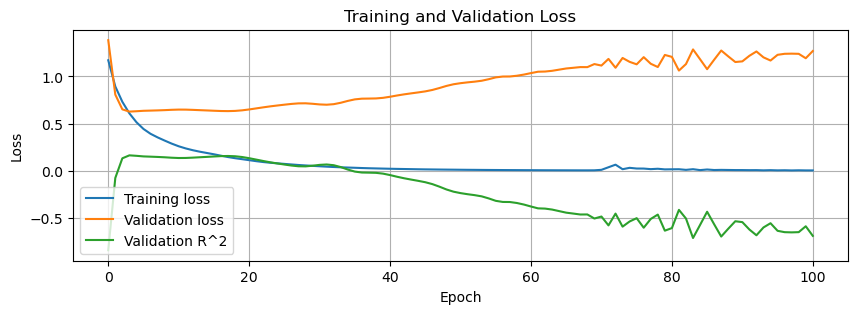

In [43]:
model, training_loss, validation_loss, validation_r_squared, mse_losses = train_nn(X_train, 
                                                                       y_train, 
                                                                       X_valid, 
                                                                       y_valid, 
                                                                       num_epochs=100, 
                                                                       learning_rate=5e-4, 
                                                                       weight_decay=1e-1, 
                                                                       verbose=True,
                                                                       seed=SEED)

In [44]:
device = get_device(False)

# Get the predictions
x_valid = torch.tensor(X_valid, dtype=torch.float32).to(device)
x_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_pred = model(x_valid).clone().detach().cpu().numpy().squeeze()
y_pred_train = model(x_train).clone().detach().cpu().numpy().squeeze()

In [45]:
# Associate the result by country and add 'Set' column
y_pred_country = pd.DataFrame({
    'date': preprocessor.dates_valid,
    'country': preprocessor.country_valid,
    'y_pred': y_pred,
    'y_true': y_valid,
    'Set': 'Validation'
})

y_pred_train_country = pd.DataFrame({
    'date': preprocessor.dates_train,
    'country': preprocessor.country_train,
    'y_pred': y_pred_train,
    'y_true': y_train,
    'Set': 'Training'
})


In [46]:
# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country", "Set"],
    value_vars=["y_pred", "y_true"], 
    var_name="Type", value_name="Value"
)

# Function to plot data for the selected country
def plot_by_country(selected_country, predictions_melted=predictions_melted):
    filtered_data = predictions_melted[predictions_melted["country"] == selected_country]
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", errorbar = None, style="Set", markers=True
    )
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown, predictions_melted=widgets.fixed(predictions_melted)) 

plt.show()


interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Korea', 'Switzerland', '…

### Using the Kalman Filter on high frequency data

In [47]:
preprocessor.dates_high_freq
preprocessor.country_high_freq

df_hf = pd.DataFrame({
    'date': preprocessor.dates_high_freq,
    'country': preprocessor.country_high_freq,
    'data': [x_hf[i] for i in range(len(x_hf))]
})

df_x_train = pd.DataFrame({
    'date': preprocessor.dates_train.copy(),
    'country': preprocessor.country_train.copy(),
    'data': [X_train[i].copy() for i in range(len(X_train))],
    'true': [y_train[i].copy() for i in range(len(y_train))]
})

df_hf['date'] = pd.to_datetime(df_hf['date'])
df_x_train['date'] = pd.to_datetime(df_x_train['date'])

In [48]:
def apply_kalman_filter(model, preprocessor, use_true_values=False, seed=42, accurate_noise_var=None, accel_var=1e-5):
    # Based on true GDP data, to be used as low error measurements
    true_data = pd.DataFrame({
        'date': preprocessor.dates_train,
        'country': preprocessor.country_train,
        'pred': model(torch.tensor(preprocessor.X_train, dtype=torch.float32).to(device)).clone().detach().cpu().numpy().squeeze(),
        'y': preprocessor.y_train,
    }).sort_values(by=['date', 'country']).reset_index(drop=True)

    # Remove the duplicates (due to data augmentation)
    true_data = true_data.drop_duplicates(subset=['date', 'country'], keep='first', ignore_index=True)

    # The measurements (high freq predictions) that we want to smooth
    hf_data = pd.DataFrame({
        'date': preprocessor.dates_high_freq,
        'country': preprocessor.country_high_freq,
        'y_pred': model(torch.tensor(preprocessor.x_high_freq, dtype=torch.float32).to(device)).clone().detach().cpu().numpy().squeeze(),
        'Set': 'High Frequency',
    }).sort_values(by=['date', 'country']).reset_index(drop=True)

    # To store the smoothed results
    kf_data = hf_data.copy().assign(y_kf=None)

    # Fit the Kalman filter on the true data (initializes initial state)
    kf = KF()
    kf.fit(true_data['pred'].values, true_data['y'].values, true_data['country'].values, accel_var=accel_var)

    for date in df_hf['date'].unique():
        mask = lambda df: df['date'] == date
        
        true_masked = true_data[mask(true_data)]

        nn_masked = hf_data[mask(hf_data)]
        # Keep only those for which we do not have accurate data
        nn_masked = nn_masked[~nn_masked['country'].isin(true_masked['country'])]

        if use_true_values and true_masked.shape[0] > 0:
            kf_predictions = kf.accurate_predict_update(y=true_masked['y'], countries=true_masked['country'], noise_var=accurate_noise_var)
            kf_data.loc[kf_data['country'].isin(true_masked['country']) & mask(kf_data), 'y_kf'] = kf_predictions


        if nn_masked.shape[0] > 0:
            kf_predictions = kf.predict_update(y=nn_masked['y_pred'], countries=nn_masked['country'])
            kf_data.loc[kf_data['country'].isin(nn_masked['country']) & mask(kf_data), 'y_kf'] = kf_predictions

    kf_predictions_melted = kf_data.melt(
        id_vars=["date", "country", "Set"],
        value_vars=["y_kf"], 
        var_name="Type", 
        value_name="Value"
    )

    hf_data_melted = hf_data.melt(
        id_vars=["date", "country", "Set"],
        value_vars=["y_pred"], 
        var_name="Type", 
        value_name="Value"
    )

    return kf_predictions_melted, hf_data_melted

kf_predictions_melted, hf_data_melted = apply_kalman_filter(model, preprocessor, use_true_values=False, seed=SEED, accurate_noise_var=0, accel_var=8e-6)

all_predictions_merged = pd.concat([predictions_melted[predictions_melted['Type'] != 'y_pred'], kf_predictions_melted, hf_data_melted], ignore_index=True)

# Create a dropdown widget for selecting the country
countries = all_predictions_merged["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown, predictions_melted=widgets.fixed(all_predictions_merged))
plt.show()

interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Korea', 'Switzerland', '…

In [49]:
kf_predictions_melted, hf_data_melted = apply_kalman_filter(model, preprocessor, use_true_values=True, seed=SEED, accurate_noise_var=5e-4, accel_var=8e-6)

all_predictions_merged = pd.concat([predictions_melted[predictions_melted['Type'] != 'y_pred'], kf_predictions_melted, hf_data_melted], ignore_index=True)

# Create a dropdown widget for selecting the country
countries = all_predictions_merged["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown, predictions_melted=widgets.fixed(all_predictions_merged))
plt.show()

interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Korea', 'Switzerland', '…

In [50]:
df_preds = all_predictions_merged[all_predictions_merged['Type'] == 'y_pred']

# Compute per country
smoothness_values = []
for country in df_preds['country'].unique():
    country_data = df_preds[df_preds['country'] == country]
    
    smoothness_values_per_func = []
    for smoothness_func in results.all_smoothness_metrics:
        smoothness_values_per_func.append(smoothness_func(country_data['Value'].values))

    smoothness_values.append(smoothness_values_per_func)

harmonic_mean_loss = np.expm1(np.mean(np.log1p(smoothness_values)))

print(f"Harmonic mean of smoothness metrics: {harmonic_mean_loss}")

Harmonic mean of smoothness metrics: (0.40303742545611165-8.81276981409221e-20j)
